# 森林火灾模拟

之前我们已经构建好了一些基础，但是还没有开始对火灾进行模拟。

## 随机生长

- 在原来的基础上,我们要先让树生长，即定义 `grow_trees()` 方法
- 定义方法之前，我们要先指定两个属性：
    - 每个位置随机生长出树木的概率
    - 每个位置随机被闪电击中的概率
- 为了方便，我们定义一个辅助函数来生成随机 `bool` 矩阵，大小与森林大小一致
- 按照给定的生长概率生成生长的位置，将 `trees` 中相应位置设为 `True`

In [1]:
import numpy as np

class Forest(object):
    """ Forest can grow trees which eventually die."""
    def __init__(self, size=(150,150), p_sapling=0.0025, p_lightning=5.0e-6):
        self.size = size
        self.trees = np.zeros(self.size, dtype=bool)
        self.fires = np.zeros((self.size), dtype=bool)
        self.p_sapling = p_sapling
        self.p_lightning = p_lightning
        
    def __repr__(self):
        my_repr = "{}(size={})".format(self.__class__.__name__, self.size)
        return my_repr
    
    def __str__(self):
        return self.__class__.__name__
    
    @property
    def num_cells(self):
        """Number of cells available for growing trees"""
        return np.prod(self.size)
    
    @property
    def tree_fraction(self):
        """
        Fraction of trees
        """
        num_trees = self.trees.sum()
        return float(num_trees) / self.num_cells
    
    @property
    def fire_fraction(self):
        """
        Fraction of fires
        """
        num_fires = self.fires.sum()
        return float(num_fires) / self.num_cells
    
    def _rand_bool(self, p):
        """
        Random boolean distributed according to p, less than p will be True
        """
        return np.random.uniform(size=self.trees.shape) < p
    
    def grow_trees(self):
        """
        Growing trees.
        """
        growth_sites = self._rand_bool(self.p_sapling)
        self.trees[growth_sites] = True

测试：

In [2]:
forest = Forest()
print forest.tree_fraction

forest.grow_trees()
print forest.tree_fraction

0.0
0.00293333333333


## 火灾模拟

- 定义 `start_fires()`：
    - 按照给定的概率生成被闪电击中的位置
    - 如果闪电击中的位置有树，那么将其设为着火点
- 定义 `burn_trees()`：
    - 如果一棵树的上下左右有火，那么这棵树也会着火
- 定义 `advance_one_step()`：
    - 进行一次生长，起火，燃烧

In [3]:
import numpy as np

class Forest(object):
    """ Forest can grow trees which eventually die."""
    def __init__(self, size=(150,150), p_sapling=0.0025, p_lightning=5.0e-6):
        self.size = size
        self.trees = np.zeros(self.size, dtype=bool)
        self.fires = np.zeros((self.size), dtype=bool)
        self.p_sapling = p_sapling
        self.p_lightning = p_lightning
        
    def __repr__(self):
        my_repr = "{}(size={})".format(self.__class__.__name__, self.size)
        return my_repr
    
    def __str__(self):
        return self.__class__.__name__
    
    @property
    def num_cells(self):
        """Number of cells available for growing trees"""
        return np.prod(self.size)
    
    @property
    def tree_fraction(self):
        """
        Fraction of trees
        """
        num_trees = self.trees.sum()
        return float(num_trees) / self.num_cells
    
    @property
    def fire_fraction(self):
        """
        Fraction of fires
        """
        num_fires = self.fires.sum()
        return float(num_fires) / self.num_cells
    
    def _rand_bool(self, p):
        """
        Random boolean distributed according to p, less than p will be True
        """
        return np.random.uniform(size=self.trees.shape) < p
    
    def grow_trees(self):
        """
        Growing trees.
        """
        growth_sites = self._rand_bool(self.p_sapling)
        self.trees[growth_sites] = True
        
    def start_fires(self):
        """
        Start of fire.
        """
        lightning_strikes = (self._rand_bool(self.p_lightning) & 
            self.trees)
        self.fires[lightning_strikes] = True
    
    def burn_trees(self):
        """
        Burn trees.
        """
        fires = np.zeros((self.size[0] + 2, self.size[1] + 2), dtype=bool)
        fires[1:-1, 1:-1] = self.fires
        north = fires[:-2, 1:-1]
        south = fires[2:, 1:-1]
        east = fires[1:-1, :-2]
        west = fires[1:-1, 2:]
        new_fires = (north | south | east | west) & self.trees
        self.trees[self.fires] = False
        self.fires = new_fires
        
    def advance_one_step(self):
        """
        Advance one step
        """
        self.grow_trees()
        self.start_fires()
        self.burn_trees()

In [4]:
forest = Forest()

for i in range(100):
    forest.advance_one_step()

使用 `matshow()` 显示树木图像：

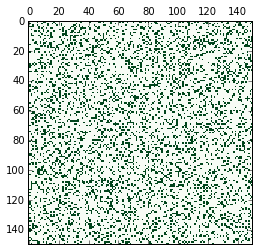

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

plt.matshow(forest.trees, cmap=cm.Greens)

plt.show()

查看不同着火概率下的森林覆盖率趋势变化：

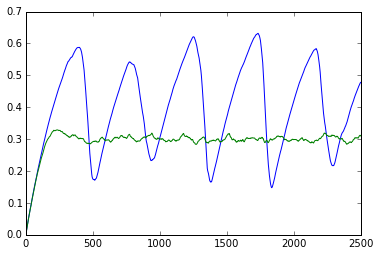

In [6]:
forest = Forest()
forest2 = Forest(p_lightning=5e-4)

tree_fractions = []

for i in range(2500):
    forest.advance_one_step()
    forest2.advance_one_step()
    tree_fractions.append((forest.tree_fraction, forest2.tree_fraction))

plt.plot(tree_fractions)

plt.show()